# Data Driven Presales Evaluation

Welcome to using the data driven jupyter notebook for evaluating if data from csv file(s) is sufficient for creating simulators using supervised learning methods. The approach of learning the state transitions, $(\underline{s}, \underline{a}) \rightarrow \underline{s}'$ from data is growing in popularity, however, not all of your data may have the correct distributions for the ranges needed for your Reinforcement Learning use case. This notebook is split up into three sections: 

- Data Relevance
- Sparsity
- Data Distribution Confidence

This notebook uses `nbgrader` package to 'grade' your data quality, distributions, and feasibility of creating approximated simulations from your data. A score of 100 means you passed all the tests. The tests basically consists of assert conditions that individual notebook cells must run successfully, require user input of `Y/N` that you agree, or requiring inputs of Subject Matter Expert (SME) data ranges. The `nbgrader` package allows for certain snippets of code to be hidden from you to simplify the usage of this notebook. When code is hidden from you, you will know because the cell can NO longer be edited in jupyter notebook.

> To pass tests, you may have to create a new cell and write code to filter/smooth/manipulate your data 

Successfully run all cells to assess whether or not a data driven simulator can be adequately created from your data. Once you have ran the cells without assertion errors, quickly double check your script passes the tests by click the `Validate` button in the jupyter notebook. If all tests are passed, then please export this as a PDF to share.

In [1]:
import pandas as pd
from scipy import stats
import numpy as np
import os
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import yaml

gitroot = os.popen('git rev-parse --show-toplevel').read()
os.chdir(gitroot.rstrip())

### SECTION A: Data Relevance

- load csv file(s)
- define potential inputs/outputs
- check NaN
- define cadence of state transitions
- check outliers and plot each indiviual dataset
- check NaN after concatenating
- use feature importances to determine best features
- re-define features (inputs)
- save as single csv, named approved_data.csv

`Step 1`: Add path to filenames as strings to the `filenames` list.

In [2]:
filenames = [
    'example_data.csv',
    #'data.csv',
]

The test below simply awards 10 points if the data can be successfuly loaded into the jupyter notebook, i.e. paths are real.

In [3]:
df_list = []
for location in filenames:
    read_datafile = pd.read_csv(location)
    df_list.append(read_datafile)

`Step 2`: Add any potential feature names as states and actions to the dictionary in the following way. Here we want to be more broad than you think because this notebook will help you determine which features probably matter more using what's called feature importances (to be looked at later).

```python
config['IO']['feature_name'] = {
    'name1': 'state',
    'name2': 'state',
    'name3': 'action',
}
```

In [4]:
with open('config/config_model.yml') as conf:
    config = yaml.full_load(conf)

# TODO: Modify dictionary for as 'feature_name': 'action' or 'state'
config['IO']['feature_name'] = {
    'theta': 'state',
    'alpha': 'state',
    'theta_dot': 'state',
    'alpha_dot': 'state',
    'Vm': 'action',
}

`Step 3`: Add the desired states to be predicted from the supervised learning simulator. Typically it is the next state after a timestep, $(\underline{s}, \underline{a}) \rightarrow \underline{s}'$. However, they may be additional features in the data that you may wish to actually predict. This is okay too, just make sure to have sufficient proxy information in the features to determine it.

```python
config['IO']['output_name'] = [
    'name1',
    'name2',
]
```

In [5]:
# TODO: Modify list to consist of predicted states
config['IO']['output_name'] = [
    'theta',
    'alpha',
    'theta_dot',
    'alpha_dot',
]

with open('config/config_model.yml', 'w') as conf:
    yaml.dump(config, conf, sort_keys=False)

feature_names = []
for key, value in config['IO']['feature_name'].items():
    feature_names.append(key)
    
output_names = config['IO']['output_name']

req_keys = feature_names.copy()
for name in output_names:
    if name not in req_keys:
        req_keys.append(name)

The test below checks if there are NaN (Not a Number), strings, or objects based upon each csv. Building a data driven simulator using supervised learning methods must be provided numbers, it must be processed. You will be provided with which columns of which datasets have improper types.

In [16]:
## Check for strings, nans, other datatypes than numbers

### BEGIN HIDDEN TESTS

def hasNaN(x_set):
    nan_catcher = np.zeros((1, x_set.shape[1]))
    catcher = []

    if isinstance(x_set, pd.DataFrame):
        i = 0
        for column_name, column_data in x_set.iteritems():
            catcher_col = []
            if column_data.dtype == 'object':
                for row in column_data.values:
                    if pd.isnull(row):
                        nan_catcher[0, i] += 1
                    else:
                        try:
                            row = float(row)
                        except:
                            catcher_col.append(row)
            else:
                pass
            catcher.append(catcher_col)
            i += 1

    elif isinstance(x_set, np.ndarray):
        for i in range (0, x_set.shape[1]):
            catcher_col = []
            for j in range(x_set.shape[0]):
                if type(x_set[j, i]) == str or type(x_set[j, i]) == list or type(x_set[j, i]) == dict or type(x_set[j, i]) == tuple:
                    try:
                        row = float(x_set[j, i])
                    except:
                        catcher_col.append(x_set[j, i])
                elif pd.isnull(x_set[j, i]):
                    nan_catcher[0, i] += 1
                else:
                    pass
            catcher.append(catcher_col)
    else:
        print('Please input pandas dataframe or numpy array')
        exit()
    return nan_catcher, catcher

check_nan = []
check_ = []
for i, df in enumerate(df_list):
    print('data set: {}'.format(filenames[i]))
    nan_count, _ = hasNaN(df[req_keys])
    check_nan.append(nan_count)
    check_.append(_)
    for i in range(0, df[req_keys].shape[1]):
        print('Detected {} NaN and the following issues in column, {}:  {}'.format(int(nan_count[0, i]), req_keys[i],  _[i]))

for dataset in check_nan:
    for col in dataset:
        assert(col.any() < 1), "NaNs were detected, remove."
for dataset in check_:
    for col in dataset:
        assert(len(col) == 0), "Remove undesired data samples tagged above."
### END HIDDEN TESTS

data set: example_data.csv
Detected 0 NaN and the following issues in column, theta:  []
Detected 0 NaN and the following issues in column, alpha:  []
Detected 0 NaN and the following issues in column, theta_dot:  []
Detected 0 NaN and the following issues in column, alpha_dot:  []
Detected 0 NaN and the following issues in column, Vm:  []
[]
[]
[]
[]
[]


`Step 4`: Change the timelag or the number of iterations that span between the state transition, $(\underline{s}, \underline{a}) \rightarrow \underline{s}'$. Think of this as the number of rows in the csv that dictate the timestep between a "steady state" transition, where a change in an input to the system will be reflected after this many sample measurements.

In [7]:
timelag = 1

The test below finds outliers for each dataset, plots the original states and actions with overlayed outliers marked. Outliers can occur due to noisy sensors, conditions that are abnormal, or if the Signal is Not Available (SNA) where it defaults to a really large or small number.

- fits to data in single csv, check for if any data is outside 3 std
- plots states and actions, overlayed with outliers

Using TensorFlow backend.


data set: example_data.csv
computing Outliers ....
y 0 :  [15084 73740]
y 1 :  []
y 2 :  [92003]
y 3 :  []


None

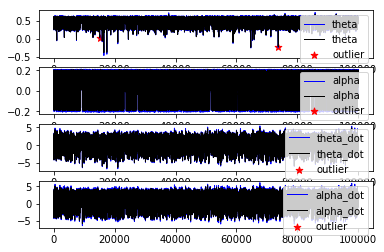

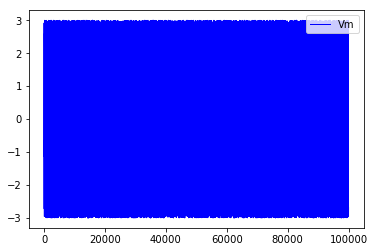

In [8]:
## Check for Outliers

### BEGIN HIDDEN TESTS

from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from env_data_modeler import env_gb_modeler

def plotOutliers(y_set, y_predict_all, outlier_data, config):
    fig = plt.figure()
    numSubPlots = y_set.shape[1]

    outlierData = outlier_data['y' + str(0)]
    dataLabel = []
    for key, value in config['IO']['feature_name'].items():
        if value == 'state':
            dataLabel.append(key)

    ax1 = plt.subplot(numSubPlots, 1, 0+1)
    plt.plot(y_set[:,0], label=dataLabel[0], linewidth=1, color = 'blue' )
    plt.plot(y_predict_all[0], label=dataLabel[0], linewidth=1, color = 'black' )
    plt.scatter(outlierData,y_set[outlierData,0], label='outlier', linewidth=1, marker = '*', color = 'red', s = 50)
    plt.xticks(rotation='horizontal')
    plt.legend(loc='upper right')
    
    for i in range(1,numSubPlots):        
        outlierData = outlier_data['y' + str(i)]

        ax2 = plt.subplot(numSubPlots, 1, i+1, sharex=ax1)
        plt.plot(y_set[:,i], label=dataLabel[i], linewidth=1, color = 'blue' )
        plt.plot(y_predict_all[i], label=dataLabel[i], linewidth=1, color = 'black' )
        plt.scatter(outlierData,y_set[outlierData,i], label='outlier', linewidth=1, marker = '*', color = 'red', s = 50)
        plt.xticks(rotation='horizontal')
        plt.legend(loc='upper right')

    # plt.show()
    
def findOutliersAll(x_set,y_set, thrhld=2):
    ## Computing Feature importance using gradient boosting
    print('computing Outliers ....')
    outlier_data = {}
    y_predict_all = []
    for i in range (0, y_set.shape[1]):
        gb_estimator=GradientBoostingRegressor(n_iter_no_change=50, validation_fraction=.2)
        gb_model= gb_estimator.fit(x_set,y_set[:,i])
        y_predict = gb_estimator.predict(x_set)
        outlier_data['y' + str(i)] = findOutlier(y_set[:,i], y_predict, thrhld=thrhld)
        y_predict_all.append(y_predict)
        print('y', str(i), ': ', outlier_data['y' + str(i)])
    return outlier_data, y_predict_all

def findOutlier(y, y_predict, thrhld=2):
    y_std = y.std(axis = 0)
    outL = np.where(np.abs(y-y_predict) > thrhld*y_std) # tuple
    return outL[0]

def plotInputs(x_set, y_set, config):
    fig = plt.figure()
    numSubPlots = x_set.shape[1] - y_set.shape[1]  ## Num of inputs
    
    dataLabel = []
    for key, value in config['IO']['feature_name'].items():
        if value == 'action':
            dataLabel.append(key)
    ax1 = plt.subplot(numSubPlots, 1, 1)
    plt.plot(x_set[:,y_set.shape[1]+0], label=dataLabel[0], linewidth=1, color = 'blue' )
    plt.xticks(rotation='horizontal')
    plt.legend(loc='upper right')
    
    for i in range(1,numSubPlots):
        ax2 = plt.subplot(numSubPlots, 1, i+1, sharex=ax1)
        plt.plot(x_set[:,y_set.shape[1]+i], label=dataLabel[i], linewidth=1, color = 'blue' )
        plt.xticks(rotation='horizontal')
        plt.legend(loc='upper right')

    # plt.show()
    return fig

def maxMinMeanStd(x, varName = 'x'):
    return x.min(axis = 0), x.max(axis = 0), x.mean(axis = 0), x.std(axis = 0)

def df_to_set(logdf, timelag=1):
    state_key_list = []
    action_key_list = []
    for key, value in config['IO']['feature_name'].items():
        if value == 'state':
            state_key_list.append(key)
        elif value == 'action':
            action_key_list.append(key)
        else:
            print('Please fix config_model.yml to specify either state or action')
            exit()
    output_key_list = config['IO']['output_name']

    outputs = logdf[output_key_list]
    states = logdf[state_key_list]
    actions = logdf[action_key_list]

    states_t = states.iloc[0:-timelag]
    states_tplus1 = outputs.iloc[timelag:]
    len(states_t)
    len(states_tplus1)
    actions_t = actions.iloc[0:-timelag]
    frames = [states_t, actions_t]
    x_set_df = pd.concat(frames, axis=1)
    y_set_df = states_tplus1
    
    x_set = x_set_df.to_numpy()
    y_set = y_set_df.to_numpy()
    
    return x_set, y_set

for i, df in enumerate(df_list):
    print('data set: {}'.format(filenames[i]))
    x_set, y_set = df_to_set(df[req_keys])
    outlier_data, y_predict_all = findOutliersAll(x_set, y_set, thrhld=3)
    fig = plotOutliers(y_set, y_predict_all, outlier_data, config)
    plotInputs(x_set, y_set, config)
    display(fig)

### END HIDDEN TESTS

`Step 5`: The notebook will prompt you to accept `Y/N` with the outliers. It is okay to have a few as long as they make sense to you and are not going to interrupt learning the normal conditions you expect the simulator to model (not abnormal).

If you need to manipulate the data further, Enter `N`.

In [9]:
accept_outliers = input('Do you accept the outliers in the following dataset? Enter "Yes". If not, type "No" and filter or smooth data: ')

assert(accept_outliers == 'Yes' or accept_outliers == 'yes' or accept_outliers == 'y' or accept_outliers == 'Y'), "Manipulate data to smooth and filter to remove outliers before step 5, then re-run cells up until this point again"

Do you accept the outliers in the following dataset? Enter "Yes". If not, type "No" and filter or smooth data: Y


After accepting the outliers, this notebook will concatenate the data and check for NaNs again due to any datasets missing features (columns).

In [19]:
dfs = pd.DataFrame()
for df in df_list:
  dfs = pd.concat([dfs, df[req_keys]], sort=False)

print(dfs.head())

### BEGIN HIDDEN TESTS
nan_count, _ = hasNaN(df[req_keys])
for i in range(0, df[req_keys].shape[1]):
        print('Detected {} NaN and the following issues in column, {}:  {}'.format(int(nan_count[0, i]), req_keys[i],  _[i]))

for col in nan_count:
    assert(col.any() < 1), "NaNs were detected, remove."
for col in _:
    assert(len(col) == 0), "Remove undesired data samples tagged above."
### END HIDDEN TESTS

      theta     alpha  theta_dot  alpha_dot        Vm
0  0.506145  0.038554  -0.017386   0.008774 -0.652841
1  0.506380  0.038924   0.134700   0.176485 -0.997206
2  0.507359  0.040100   0.354600   0.411214  0.306137
3  0.508701  0.041705   0.316602   0.391761  2.492230
4  0.509028  0.042383  -0.152600  -0.052578 -2.165399
Detected 0 NaN and the following issues in column, theta:  []
Detected 0 NaN and the following issues in column, alpha:  []
Detected 0 NaN and the following issues in column, theta_dot:  []
Detected 0 NaN and the following issues in column, alpha_dot:  []
Detected 0 NaN and the following issues in column, Vm:  []


We have now qualified your datasets enough to export it to a single csv, named `processed_data.csv`. You have now finished the first section of `Data Relevance`. This does NOT say anything about data sparsity and distribution confidence, which are the next two sections.

In [21]:
from datamodeler import csv_to_pickle

dfs.to_csv('processed_data.csv', mode='w', index=False)

csv_to_pickle('processed_data.csv', timelag=timelag)

x_set_shape is (99999, 5)
y_set_shape is: (99999, 4)


Below determines the `feature importances`, which are quantifying the inputs that are most valuable in explaining the target variable. The feature importances add up to one when summed, where the largest value is the most important feature. This is a useful trick in designing inputs/ouputs for supervised learning. We determine the feature importances for each of the predicted outputs, based on the features provided in cells above. They are then plotted where a legend designates the predicted value.

> If you are NOT satisfied with your chosen model inputs, modify the inputs in the cell above and run through all the cells leading up to this again.

computing Feature Importance ....
feature importance for theta'  : [9.29390235e-01 6.29508311e-02 4.72061802e-03 2.83410272e-03
 1.04213074e-04]
feature importance for alpha'  : [3.20025425e-04 9.88393473e-01 1.62267174e-04 1.10598025e-02
 6.44318304e-05]
feature importance for theta_dot'  : [1.65703110e-04 6.14763390e-02 8.85330057e-01 2.66671358e-03
 5.03611870e-02]
feature importance for alpha_dot'  : [1.78375425e-04 7.85116252e-02 2.43130220e-03 8.81186169e-01
 3.76925277e-02]


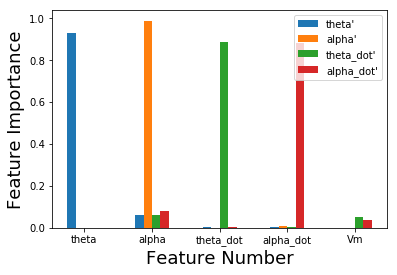

In [23]:
## Feature Importances

### BEGIN HIDDEN TESTS
from sklearn.model_selection import train_test_split
from env_data_modeler import env_gb_modeler
from datamodeler import read_env_data

def feature_plots(feature_data, state_space_dim, action_space_dim, config, total_width=0.5):
    fig, ax = plt.subplots()

    colors = plt.rcParams['axes.prop_cycle'].by_key()['color']  
    n_bars = len(feature_data)
    bar_width = total_width / n_bars # width of single bar
    bars = []
    for i, (name, values) in enumerate(feature_data.items()):
        x_offset = (i - n_bars / 2) * bar_width + bar_width / 2
        for x, y in enumerate(values):
            bar = ax.bar(x + x_offset, y, width=bar_width , color=colors[i % len(colors)])
        bars.append(bar[0])


    ax.legend(bars, feature_data.keys())
    plt.xlabel('Feature Number', fontsize=18)
    plt.ylabel('Feature Importance', fontsize=18)

    plt.xticks(ticks=range(state_space_dim+action_space_dim), labels=config['IO']['feature_name'].keys())
    plt.show()

state_space_dim = 0
action_space_dim = 0
for key, value in config['IO']['feature_name'].items():
    if value == 'state':
        state_space_dim += 1
    elif value == 'action':
        action_space_dim += 1
    else:
        print('Please fix config_model.yml to specify either state or action')
        
x_set, y_set = read_env_data()
x_train, x_test, y_train, y_test = train_test_split(x_set, y_set, test_size=0.33, random_state=42)

## Computing Feature importance using gradient boosting
print('computing Feature Importance ....')
feature_importance_data = {}
for i in range (0, y_set.shape[1]):
    gb_estimator=env_gb_modeler(state_space_dim, action_space_dim)
    gb_estimator.create_gb_model()
    gb_model= gb_estimator.train_gb_model(x_train,y_train[:,i])
    feature_importance_data[feature_names[i]+"'"] = gb_model.feature_importances_
    print('feature importance for', feature_names[i]+"'", ' :', feature_importance_data[feature_names[i]+"'"])
feature_plots(feature_importance_data, state_space_dim, action_space_dim, config, total_width=0.5)
### END HIDDEN TESTS

`Step 6`: Enter `Y` if you accept your current model inputs and outputs, If not, Enter `N` and 

In [24]:
accept_features = input('Do you accept the features based upon the feature importances shown? Enter "Yes" to continue. (Otherwise re-enter states and actions and run through cells again):  ')

assert(accept_features == 'Yes' or accept_features == 'yes' or accept_features == 'y' or accept_features == 'Y'), "Re-enter states and actions at step 2 and re-run through cells to visualize feature importances again."

Do you accept the features based upon the feature importances shown? Enter "Yes" to continue. (Otherwise re-enter states and actions and run through cells again):  Y


### SECTION B: Sparsity

- define Subject Matter Expert (SME) limits on feature ranges
- plot histograms
- compare SME limits with data limits using 2 std

In [25]:
### Template limits to copy/paste into next cell

### BEGIN HIDDEN TESTS
sme_limits = {}
for f in feature_names:
    sme_limits.update({
        f: {
            'min': -1,
            'max': 1,
        }
    })

with open('config/sme_limits.yml', 'w') as conf:
    yaml.dump(sme_limits, conf, sort_keys=False)
    
with open('config/sme_limits.yml', 'r') as sme:
    print(sme.read())
### END HIDDEN TESTS

theta:
  min: -1
  max: 1
alpha:
  min: -1
  max: 1
theta_dot:
  min: -1
  max: 1
alpha_dot:
  min: -1
  max: 1
Vm:
  min: -1
  max: 1



`Step 7`: Modify template of min/max values for each of the features - this is where you define the Subject Matter Expert (SME) limits. Please define the range that would be reasonable to run the simulator in, despite what is captured in data. These are the limits that Reinforcement Learning will reasonably explore in to provide novel solutions.

> Copy/Paste the above template below the `%%writefile config/sme_limits.yml` line and run the cell to write to the file. 

In [26]:
%%writefile config/sme_limits.yml
theta:
  min: -1.5708
  max: 1.5708
alpha:
  min: -3.14159
  max: 3.14159
theta_dot:
  min: -7.822916413465077
  max: 7.610718493430506
alpha_dot:
  min: -12.841118663208904
  max: 11.931522401818508
Vm:
  min: -3
  max: 3

Overwriting config/sme_limits.yml


The following test will plot the histograms for each of the features and check whether or not the data's mean $\pm 2$ std is larger than the SME limits. 

> The tests assume your data has a gaussian distribution, i.e. bi-modal data can be problematic. 

AssertionError: 

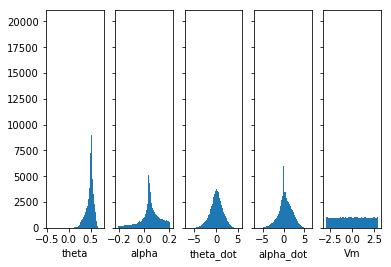

In [27]:
## Histogram and report sparsity index

### BEGIN HIDDEN TESTS
with open('config/sme_limits.yml', 'r') as sme:
    sme_limits = yaml.full_load(sme)

with open('config/model_limits.yml') as conf:
    model_limits = yaml.full_load(conf)
    
fig, axs = plt.subplots(1, len(feature_names), sharey=True)
for i, f in enumerate(feature_names):
    (n, bins, patches) = axs[i].hist(x_set[:, i], bins=100)
    plt.setp(axs[i], xlabel=feature_names[i])

for key in config['IO']['feature_name'].keys():
    model_mean = model_limits[key]['mean']
    model_std = model_limits[key]['std']
    assert(model_mean + 2 * model_std >= sme_limits[key]['max'] and model_mean - 2 * model_std <= sme_limits[key]['min'])
### END HIDDEN TESTS

### SECTION C: Data Distribution Trust (Confidence on Interpolation)

- evaluate region confidence with model upper bound with 2 std from mean
- evaluate region confidence with model lower bound with 2 std from mean
- evaluate region confidence with SME max
- evaluate region confidence with SME min

We use a Gaussian Mixture Model (GMM) to fit to the data to be able to cluster distributions with means and covariances. We can then sample the GMM with a random state-action pair and evaluate the regions to trust based compared to SME desired limits. 

In [28]:
## Create GMM using the same number of components as the number of features

### BEGIN HIDDEN TESTS
from sklearn.decomposition import PCA

pca = PCA(0.99, random_state=0)
pca_data = pca.fit_transform(dfs)
initial_n_components = pca_data.shape[1]

from sklearn.mixture import GaussianMixture

bic_list = []
upper_comp = 20
print('Evaluating best number of components for fitting using GMM...')
for i in range(initial_n_components, initial_n_components+upper_comp, 2):
    gmm = GaussianMixture(
        n_components=i,
        covariance_type='full',
        random_state=0
    )
    gmm.fit(dfs)
    bic_list.append(gmm.bic(dfs))   
    print('{} of {}...'.format(i, initial_n_components+upper_comp))
    
n_components = bic_list.index(min(bic_list))+len(feature_names)
print('picking {} components using Bayesian Information Criterion'.format(n_components))

gmm = GaussianMixture(
    n_components=n_components,
    covariance_type='full',
    random_state=0
)

gmm.fit(dfs)

#print(gmm.means_)
#print(gmm.covariances_)

### END HIDDEN TESTS

Evaluating best number of components for fitting using GMM...
3 of 23...
5 of 23...
7 of 23...
9 of 23...
11 of 23...
13 of 23...
15 of 23...
17 of 23...
19 of 23...
21 of 23...
picking 13 components using Bayesian Information Criterion


GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
                means_init=None, n_components=13, n_init=1,
                precisions_init=None, random_state=0, reg_covar=1e-06,
                tol=0.001, verbose=0, verbose_interval=10, warm_start=False,
                weights_init=None)

In [29]:
## Evaluate region confidence with model upper bound with 2 std from mean

### BEGIN HIDDEN TESTS
sample = []
for feature_name in feature_names:
    sample.append(model_limits[feature_name]['mean']+2*model_limits[feature_name]['std'])
sample = np.array(sample).reshape(1, len(feature_names))
print('sample within model max: {}'.format(sample))
prob_result = gmm.predict_proba(sample)
print('probability', np.ravel(prob_result))

threshold = 0.5
most_likely = max(np.ravel(prob_result))
assert(most_likely > threshold and most_likely != 1 )
### END HIDDEN TESTS

sample within model max: [[0.65809018 0.20320077 2.90525318 3.67264205 3.45178318]]
probability [4.31288391e-44 1.17647791e-04 6.13293204e-01 1.38820203e-03
 2.38302046e-02 5.70715529e-68 1.87206332e-08 1.37135590e-05
 6.97805065e-05 3.05629896e-02 5.59794694e-04 3.30164445e-01
 0.00000000e+00]


In [30]:
## Evaluate region confidence with model lower bound with 2 std from mean

### BEGIN HIDDEN TESTS
sample = []
for feature_name in feature_names:
    sample.append(model_limits[feature_name]['mean']-2*model_limits[feature_name]['std'])
sample = np.array(sample).reshape(1, len(feature_names))
print('sample within model min: {}'.format(sample))    
prob_result = gmm.predict_proba(sample)
print('probability', np.ravel(prob_result))

most_likely = max(np.ravel(prob_result))
assert(most_likely > threshold and most_likely != 1 )
### END HIDDEN TESTS

sample within model min: [[ 0.310451   -0.11436953 -2.81625473 -2.83559476 -3.45991471]]
probability [1.11163672e-001 3.89300641e-019 7.41099559e-032 4.38049375e-003
 2.00885043e-028 9.00855947e-228 1.41951758e-088 6.67852243e-003
 1.03245990e-014 1.14145098e-001 7.63632214e-001 2.52129262e-025
 0.00000000e+000]


In [31]:
## Evaluate region confidence with SME max

### BEGIN HIDDEN TESTS
sample = []
for feature_name in feature_names:
    sample.append(sme_limits[feature_name]['max'])
sample = np.array(sample).reshape(1, len(feature_names))
print('sample at SME max: {}'.format(sample))
prob_result = gmm.predict_proba(sample)
print('probability', np.ravel(prob_result))

most_likely = max(np.ravel(prob_result))
assert(most_likely > threshold and most_likely != 1 )
### END HIDDEN TESTS

sample at SME max: [[ 1.5708      3.14159     7.61071849 11.9315224   3.        ]]
probability [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


AssertionError: 

In [32]:
## Evaluate region confidence with SME min

### BEGIN HIDDEN TESTS
sample = []
for feature_name in feature_names:
    sample.append(sme_limits[feature_name]['min'])
sample = np.array(sample).reshape(1, len(feature_names))
print('sample at SME min: {}'.format(sample))
prob_result = gmm.predict_proba(sample)
print('probability', np.ravel(prob_result))

most_likely = max(np.ravel(prob_result))
assert(most_likely > threshold and most_likely != 1 )
### END HIDDEN TESTS

sample at SME min: [[ -1.5708      -3.14159     -7.82291641 -12.84111866  -3.        ]]
probability [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


AssertionError: 